# Predicción de Mercados usando Tensorflow

### Import de librerías

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from datetime import datetime

### Import de los datos

In [9]:
data = pd.read_csv('./stocks/TSLA_5yr.csv')
print(data.shape)
print(data.sample(7))

data['Date'] = pd.to_datetime(data['Date'])

(1258, 7)
            Date        Open        High         Low       Close   Adj Close  \
551   2020-06-17   65.847336   67.000000   65.504669   66.119331   66.119331   
1230  2023-02-28  210.589996  211.229996  203.750000  205.710007  205.710007   
126   2018-10-08   17.634666   17.850668   16.600000   16.704000   16.704000   
957   2022-01-26  317.476654  329.230011  302.000000  312.470001  312.470001   
274   2019-05-13   15.467333   15.498000   14.966667   15.134000   15.134000   
568   2020-07-13  110.599998  119.666000   98.073997   99.804001   99.804001   
779   2021-05-13  200.513336  202.153336  186.550003  190.563339  190.563339   

         Volume  
551   148362000  
1230  153144900  
126   202090500  
957   104867400  
274   162522000  
568   584781000  
779   132554700  


### Mostramos las velas diarias

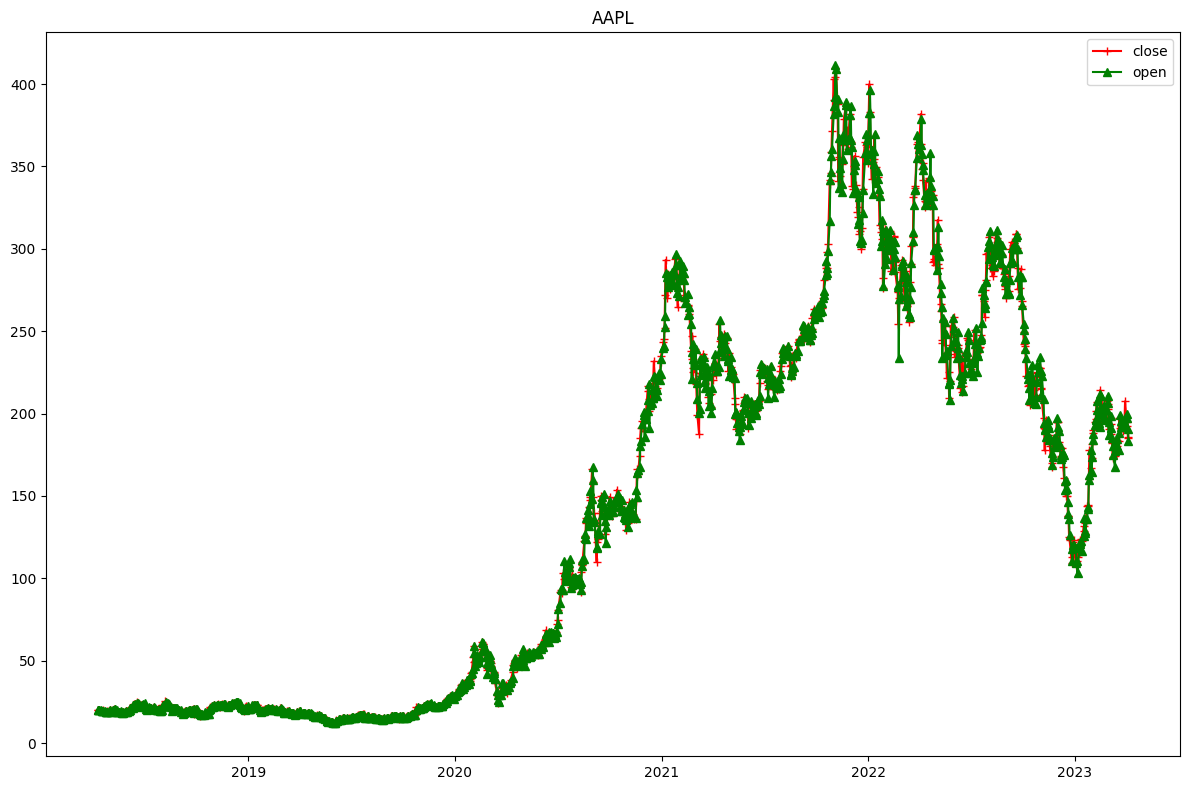

In [10]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'], c="r", label="close", marker="+")
plt.plot(data['Date'], data['Open'], c="g", label="open", marker="^")
plt.title("AAPL")
plt.legend()
plt.tight_layout()

### Mostramos el volumen diario

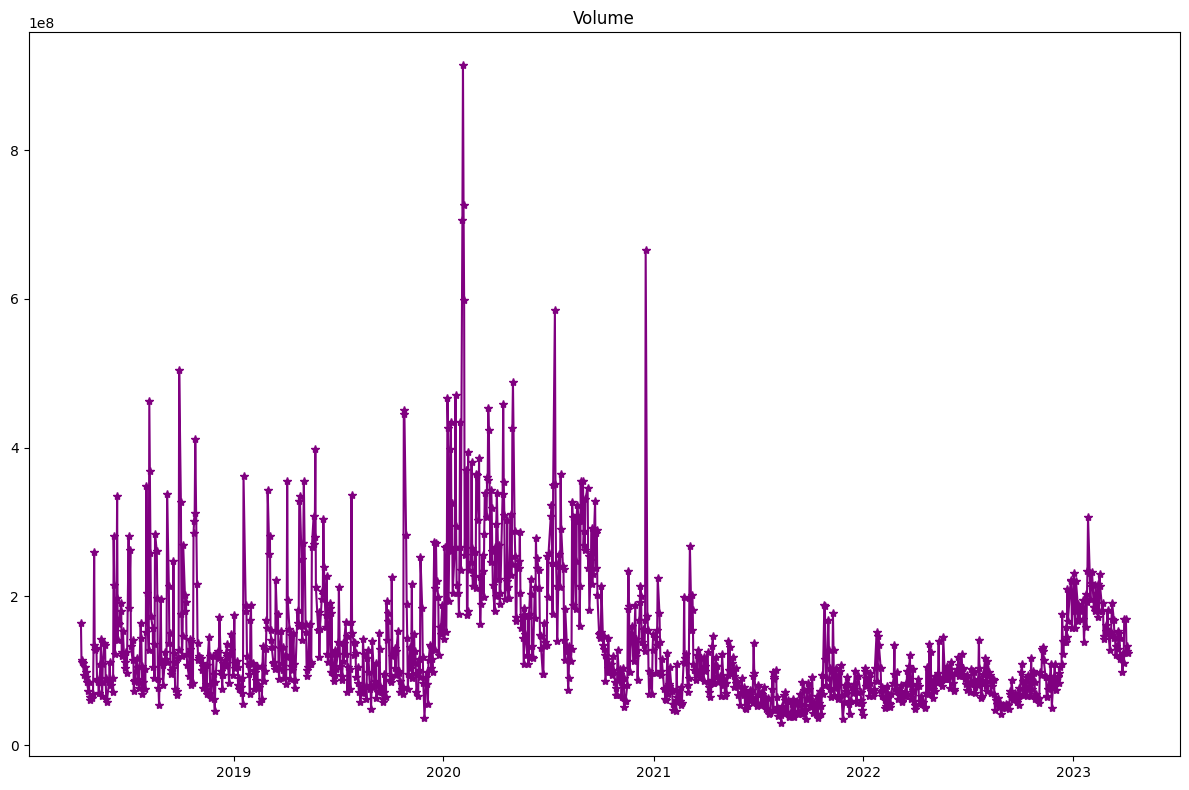

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Volume'], c='purple', marker='*')
plt.title("Volume")
plt.tight_layout()

### Mostramos los datos de entreno

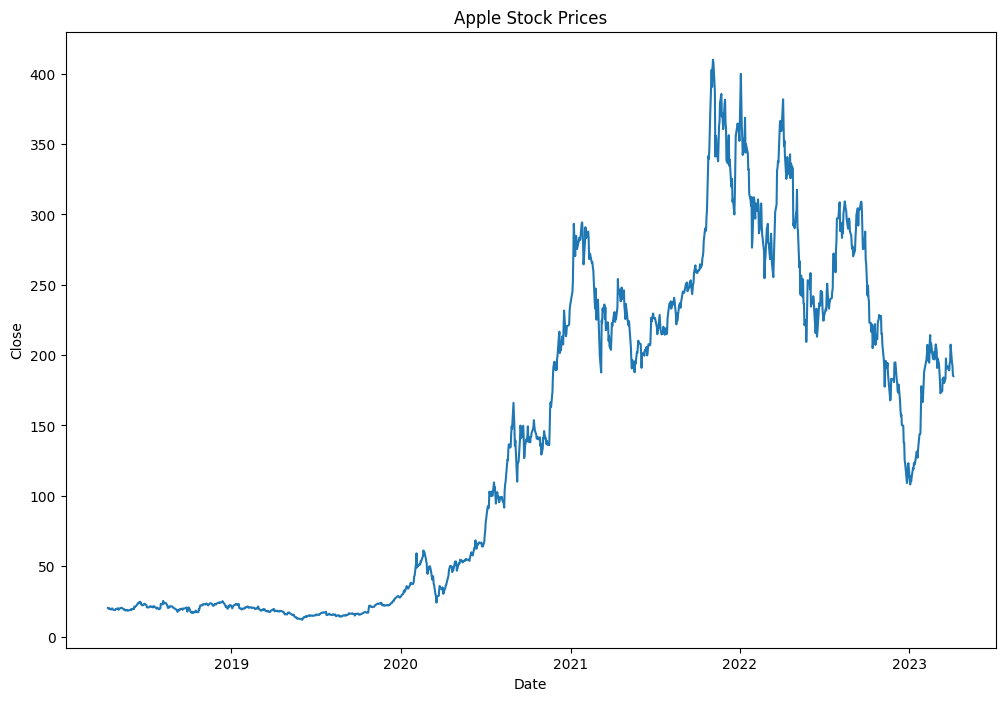

In [12]:
prediction_range = data.loc[(data['Date'] > datetime(2018,3,27)) & (data['Date'] < datetime(2023,3,27))]
plt.figure(figsize=(12, 8))
plt.plot(data['Date'], data['Close'])
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Apple Stock Prices")
plt.show()

### Establecemos el set de entrenamiento y otro para la validación (95%/5%)

In [13]:
close_data = data.filter(['Close'])
dataset = close_data.values
training = int(np.ceil(len(dataset) * .95))
testing = int(np.floor(len(dataset) * .05))
print(training)
print(testing)

1196
62


### Preparamos los datos para el entrenamiento

In [14]:
from sklearn.preprocessing import MinMaxScaler
  
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
  
train_data = scaled_data[0:int(training), :]

x_train = []
y_train = []
  
for i in range(testing, len(train_data)):
    x_train.append(train_data[i - testing:i, 0])
    y_train.append(train_data[i, 0])
  
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Preparamos el modelo

In [15]:
model = keras.models.Sequential()
model.add(keras.layers.LSTM(units=64,
							return_sequences=True,
							input_shape=(x_train.shape[1], 1)))
model.add(keras.layers.LSTM(units=64))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1))
model.summary

2023-04-10 15:08:40.823159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:08:40.826082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:08:40.827634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fc4dc3d7580>>

### Procedemos a entrenar el modelo

In [16]:
model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=10)

Epoch 1/10


2023-04-10 15:08:41.255810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:08:41.257045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:08:41.258147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 4s 37ms/step - loss: 0.0430
Epoch 2/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0092
Epoch 3/10
36/36 [==============================] - 1s 36ms/step - loss: 0.0083
Epoch 4/10
36/36 [==============================] - 1s 34ms/step - loss: 0.0078
Epoch 5/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0084
Epoch 6/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0078
Epoch 7/10
36/36 [==============================] - 1s 36ms/step - loss: 0.0070
Epoch 8/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0074
Epoch 9/10
36/36 [==============================] - 1s 35ms/step - loss: 0.0062
Epoch 10/10
36/36 [==============================] - 1s 37ms/step - loss: 0.0071


### Establecemos los datos de prueba, generamos la predicción y los MSE

In [17]:
test_data = scaled_data[training - testing:, :]

x_test = []
y_test = dataset[training:, :]
for i in range(testing, len(test_data)):
    x_test.append(test_data[i-testing:i, 0])
  
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  
# prediccion de los datos de prueba
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
  
# metricas MSE (Error Cuadrático Medio) y RMSE (Raiz del Error Cuadrático Medio)
mse = np.mean(((predictions - y_test) ** 2))
print("MSE", mse)
print("RMSE", np.sqrt(mse))

2023-04-10 15:08:56.436407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-10 15:08:56.437620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-10 15:08:56.439149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2/2 [==============================] - 0s 20ms/step
MSE 228.03785865269032
RMSE 15.100922443767809


### Mostramos el resultado final con la predicción, entrenamiento y pruebas

/tmp/ipykernel_1244/108360936.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


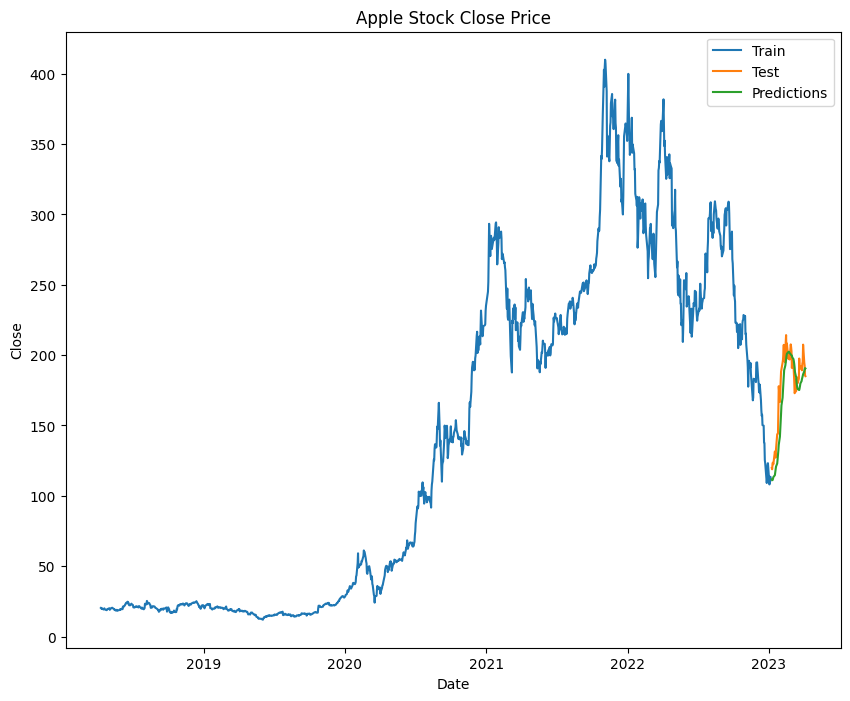

In [18]:
train = data[:training]
test = data[training:]
test['Predictions'] = predictions
  
plt.figure(figsize=(10, 8))
plt.plot(train['Date'], train['Close'])
plt.plot(test['Date'], test[['Close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('Date')
plt.ylabel("Close")
plt.legend(['Train', 'Test', 'Predictions'])
# plt.axis([2022,2023,120,180])